# Instructions

This problem set is provided in the form of a Jupyter notebook. Problems are posed within this notebook file and you are expected to provide codes and/or written answers when prompted. Remember that you can use Markdown cells to format written responses where necessary.

Before submitting your assignment, be sure to do a clean run of your notebook and **verify that your cell outputs (e.g., prints, figures, tables) are correctly shown**. To do a clean run, click *Kernel&#8594;Restart Kernal and Run All Cells...*.

You are required to submit this notebook to Gradescope in two forms:

1. Submit a PDF of the completed notebook. To produce a PDF, you can use *File&#8594;Save and Export Notebook As...&#8594;HTML* and then convert the HTML file to a PDF using your preferred web browser. **Verify that your code, written answers, and cell outputs are visible in the submitted PDF.**
2. Submit a zip file (including the `.ipynb` file) of this assignment to Gradescope.

# Problem Set 7: Using PCA for population structure correction Genome-Wide Association Studies (GWAS)


This problem set is a continuation of problem set 6, where you performed GWAS on some given genotype-phenotype data. Now, you are going to repeat that GWAS but using the principal components to correct for population structure. We are providing the encoded genotype-phenotype matrix which you calculated in the last problem set, so that everyone is starting from the same baseline. 

In [10]:
import numpy as np
import pandas as pd
from scipy import stats

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn import decomposition

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests

### Data Loading and running GWAS 

This code is (part of) the solution to problem set 6. 

In [11]:
# provided function for p-value calculation
def p_value_calculation(X2, Y, reg):
    '''
    Parameters:
    X2: np.array, the data on which the model was fit
    Y: The Y values from above (the values you are predicting)
    reg: a fit sklearn.linear_model.LinearRegression

    Returns:
    an np.array containing the p-values for the intercept and the coefficients 
    Note that the first p-value will correspond to the 
    intercept - the function prepends a ones column to X2
    
    '''
    assert (Y.shape == (1521,))
    assert (X2.shape == (1521,1) or X2.shape == (1521,4))    
    X2 = X2.astype(float)
    
    #### This chunk of code computes the p-values for the regression
    #### coefficients, which sklearn doesn't do automatically
    beta_hat = [reg.intercept_] + reg.coef_.tolist()
    n = X2.shape[0]
    
    # compute the p-values
    from scipy.stats import t
    # add ones column
    X1 = np.column_stack((np.ones(n), X2))

    # standard deviation of the noise.
    sigma_hat = np.sqrt(np.sum(np.square(Y - X1@beta_hat)) / (n - X1.shape[1]))
    
    # estimate the covariance matrix for beta 
    beta_cov = np.linalg.inv(X1.T@X1)
    
    # the t-test statistic for each variable 
    t_vals = beta_hat / (sigma_hat * np.sqrt(np.diagonal(beta_cov)))
    
    # compute 2-sided p-values.
    p_vals = t.sf(np.abs(t_vals), n-X1.shape[1])*2 
    
    return p_vals

In [12]:
encoded_data = pd.read_pickle("genotype_phenotype_data_encoded.pickle") 
## pickle is an awesome file format! It essentially allows you to save 
# pd.DataFrames on your disk and re-load them in a new notebook in 
# exactly the same format (respecting things like data types)
Y = np.log([float(x) for x in encoded_data["RIF_midpoint"]])

_tests = []
for name in encoded_data.columns[4::]: # fifth to the end are genotypes
    X2 = encoded_data.loc[:, [name]]
    reg = LinearRegression().fit(X2.values, Y)
    p_vals = p_value_calculation(X2, Y, reg)
    _tests.append([name, reg.coef_.tolist()[0], p_vals[-1]])

hit_df = pd.DataFrame(_tests, columns=["names", "beta", "pvalue"])
hit_df.sort_values("pvalue").head(5)

,names,beta,pvalue
1146,761155,2.134091,1.201605e-93
3008,2155168,-1.593196,8.814599e-50
5790,4320050,1.010421,1.533599e-17
40,17608,1.002889,2.457083e-17
1111,736710,0.999113,2.851508e-17


In [13]:
output = multipletests(hit_df.pvalue, alpha=0.001, method="bonferroni")
hit_df["is_sig_BF"] = output[0]
print("number of significant hits", hit_df.is_sig_BF.sum())

number of significant hits 615


## 01: Exploring the effects of population structure (a total of 30 points)

### 01.A: The original dataframe contains a column called "group" that gives the phylogenetic grouping from which the isolate hails. 
Calculate the overall median phenotype for RIF_midpoint, and the median within each group. Do not use the log-transformed RIF midpoint for this exploration. (10 points)

In [14]:
encoded_data

,isolate_ID,group,ROLLINGDB_ID,RIF_midpoint,71,371,1849,1977,3439,3446,...,4408094,4408156,4408413,4408528,4408920,4408923,4409954,4410309,4410386,4411016
0,00R0223,4C,00R0223,1.00,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,00R0312,4B,00R0312,1.00,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,00R0435,4C,00R0435,1.00,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,00R0453,4B,00R0453,1.00,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,00R1566,4A,00R1566,1.00,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,TDR94S189L002,4A,TDR94S189L002,0.25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1517,TDR95S190L002,4A,TDR95S190L002,0.25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1518,TDR96S191L002,2,TDR96S191L002,0.25,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1519,TDR99S194L002,2,TDR99S194L002,3.00,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
"""-- Include code here --"""

groups = encoded_data["group"].unique()
print(groups)

overall_median_RIF = encoded_data["RIF_midpoint"].median() # overall median
print("Overall median phenotype (RIF_midpoint):", overall_median_RIF)

grouped = encoded_data.groupby("group")["RIF_midpoint"] # group RIF_midpoint by "group"
median_RIF_by_group = grouped.median() # median for each group

print("Median phenotype per group:")
print(median_RIF_by_group)


['4C' '4B' '4A' '2' '1' '3']
Overall median phenotype (RIF_midpoint): 5.0
Median phenotype per group:
group
1      0.25
2      3.00
3      3.00
4A     5.00
4B    30.00
4C     5.00
Name: RIF_midpoint, dtype: float64


What is the mean phenotype value per group? (5 points)

In [ ]:
"""-- Include code here --"""

mean_RIF_by_group = grouped.mean() # mean for each group

print("Mean phenotype per group:")
print(mean_RIF_by_group)



Mean phenotype per group:
group
1      1.459839
2     13.891213
3      2.825106
4A    21.924941
4B    27.412887
4C    20.110958
Name: RIF_midpoint, dtype: float64


### 01.B Visualize the distribution of phenotypes within each group. 

Use seaborn boxplot to plot the RIF_midpoint on the Y-axis, with group on the X axis. Do not use the log-transformed RIF midpoints for this exploration. (10 points)

Make sure you label both axes of the plot and select axes limits that will include all of the data points. 


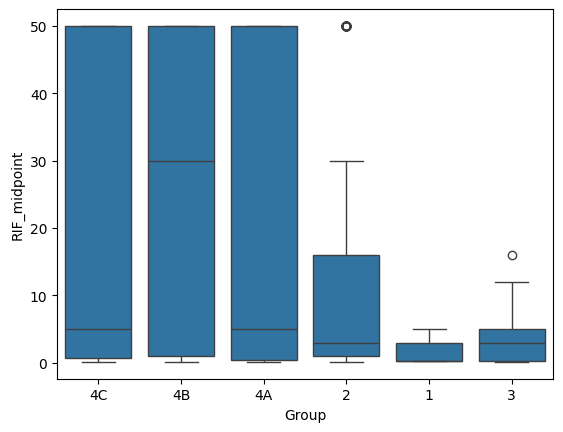

In [ ]:
"""-- Include code here --"""

sns.boxplot(
    data=encoded_data,
    x="group",
    y="RIF_midpoint"
)

plt.xlabel("Group")
plt.ylabel("RIF_midpoint")

# Set y-axis limits to include all data points
min_val = encoded_data["RIF_midpoint"].min()
max_val = encoded_data["RIF_midpoint"].max()



### 01.C: Which groups have similar distributions of resistance phenotypes? Are there any groups with very different distributions (hint, look at the median and max) (5 points)?

*Answer*: Groups 2 and 3 have similar distributions of resistance phenotypes because they both have close median values (~3.00) and relatively low mean, 13.89 and 2.83, respectively. Groups 4B, 4A, and 4C have very different distributions. 4B has an exceptionally high median (30.00) and mean (27.41), indicating consistently high resistance phenotypes in that group. Group 1 stands out given its very low median (0.25) and mean (1.46), suggesting much lower resistance compared to the others.

## 02: Compute the principal components of the genotypes in the dataset (30 points total)

For more information about PCA, please refer to https://www.datacamp.com/tutorial/principal-component-analysis-in-python.

### 02A: Calculate the PC's of your data (10 points)

Use sklearn.decomposition.PCA to fit the first 3 PC's of your data (5 points). 

What fraction of the total variance is explained by the first PC? (5 points)

In [ ]:
"""-- Include code here --"""

X = encoded_data.drop(columns=["isolate_ID", "ROLLINGDB_ID", "group", "RIF_midpoint"]) #only numeric genotype columns

pca = decomposition.PCA(n_components=3) # Fit PCA with first 3 principal components

pca.fit(X)


variance_explained = pca.explained_variance_ratio_

print("Fraction of total variance explained by PC1:", variance_explained[0]) # for the first PC


Fraction of total variance explained by PC1: 0.27563594497366056


### 02B: project your data onto the PC's (10 points)

Using pca.transform, project your encoded data onto the first three principal components. Create a dataframe called X_pc_df that has one row per isolate, each column indicating that isolate's location on the first 3 PCs. 

Add a column to X_pc_df that has the original group membership (from encoded_data) of each isolate

In [ ]:
"""-- Include code here --"""

X_pc = pca.transform(X) # transpose isolate into column

X_pc_df = pd.DataFrame(X_pc, columns=["PC1", "PC2", "PC3"])

# Add original group membership
X_pc_df["group"] = encoded_data["group"].values

X_pc_df

,PC1,PC2,PC3,group
0,-2.630446,-0.043147,8.407923,4C
1,-9.112920,-8.015451,-5.056452,4B
2,-2.657871,-0.018010,8.518359,4C
3,-9.094501,-7.997617,-5.053352,4B
4,-0.573943,7.365121,2.506206,4A
...,...,...,...,...
1516,-0.409164,2.020813,3.670641,4A
1517,-0.662924,13.355529,-3.144308,4A
1518,20.895473,-5.900959,-2.634791,2
1519,17.027186,-4.487542,-0.750702,2


### O2C: Plotting and interpretation (10 points total)

Use sns.scatterplot to plot X_pc_df. Use the 'hue' keyword argument to color each point according to its group membership (5 points)

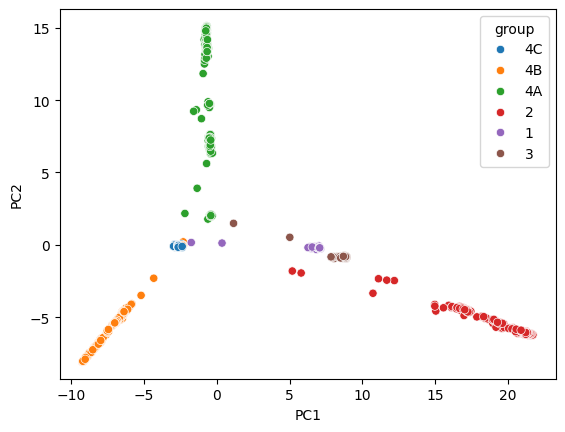

In [ ]:
"""-- Include code here --"""

# PC1 and PC2 explain the most variance (has the most spread) so make them as axes

sns.scatterplot(            
    data=X_pc_df,
    x="PC1",
    y="PC2",
    hue="group"
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


Describe in words the information being captured by PC1 in terms of the different groups of isolates. (5 points)

Answer: PC1 separates the different groups of isolates along the horizontal axis. Groups "2" (red) and "4A" (green) are well separated on the right and upper middle of the plot. Group "2" has the highest PC1 values. Groups "4B" and "4C" cluster to the left at low PC1 values, while groups "1" and "3" are near the center. Overall, PC1 separates major isolate groups from each other: group "2" (red), group "4B" (orange), and group "4A" (upper middle). Groups "1" and "3" are in the center and overlap slightly.

## 03: Correcting the GWAS (40 points total)

### O3.A: Include the first three principle components in the linear regression in order to introduce control for population structure. (20 points total)

Adapt the code given at the beginning  to now perform an association test while including the first three PCs as three additional features. We are still running one test per genotype, each test will just now include more features. For this step, you will be using the log-transformed RIF Midpoint/Y values.

We still desire the same output - giving us the name of the variant, the beta coefficient associated with the genetic variant, and the p-value associated with that variant. Report the top 5 hits in terms of p-value 

You don't need to keep the information about the beta coefficients associated with the PC features.

In [ ]:
"""-- Include code here --"""

#Y value now is log-transformed RIF_midpoint 
Y = np.log(encoded_data["RIF_midpoint"].astype(float))

PCs = X_pc_df[["PC1", "PC2", "PC3"]]


_tests = []
for feature in encoded_data.columns[4::]:  # each column is a feature to be added
    X2 = pd.concat([encoded_data[[feature]], PCs], axis=1)     # Combine variant + 3 PCs as features 
    reg = LinearRegression().fit(X2.values, Y)    
    p_vals = p_value_calculation(X2.values, Y, reg)
    _tests.append([name, reg.coef_.tolist()[0], p_vals[-1]])


hit_df = pd.DataFrame(_tests, columns=["names", "beta", "pvalue"])
hit_df.sort_values("pvalue").head(5)

,names,beta,pvalue
1226,4411016,1.978273,1.688238e-11
2485,4411016,1.974512,1.774848e-11
2215,4411016,1.979216,2.506216e-11
5510,4411016,1.952544,2.807795e-11
3744,4411016,1.948043,3.410401e-11


### 03.B: Use a Bonferroni correction for your p-values at alpha = 0.001. How many significant hits do we find now? (5 points)

You may use the multipletests function here instead of implementing your own


In [37]:
"""-- Include code here --"""

output = multipletests(hit_df.pvalue, alpha=0.001, method="bonferroni")
hit_df["is_sig_BF"] = output[0]
print("number of significant hits", hit_df.is_sig_BF.sum())



number of significant hits 303


### 03.C: Why did including PCs cause the number of significant hits to go down? What information do the PCs summarize? (15 points)

*Answer*: Including PCs caused the number of significant hits to go down because the PCs account for relatedness among isolates. In reality, many genetic variants are not independent. They are correlated due to shared ancestry or subpopulation structure. PCs adjust the model so that now only variants that have an effect on the phenotype independent of population structure are considered significant as they remove spurious associations. Including PCs reduces false positive. This explains why the number of significant hits go down. 
Overall, PCs summarize the main patterns of variation in the genotype data, capturing differences between subpopulations of related isolates.
